In [139]:
import numpy as np
import matplotlib.pyplot as plt 
import matplotlib.colors as colors
import pandas as pd 

from astropy.visualization import astropy_mpl_style
from astropy.utils.data import get_pkg_data_filename
from astropy.io import fits

from scipy.optimize import curve_fit
import scipy.stats as stat
from scipy.signal import argrelextrema
from scipy.signal import find_peaks
from scipy.misc import electrocardiogram

In [161]:
def GetImage(fitfile): 
    '''Takes: .fit file
        Returns: file, data  (n,m) for n rows and m colums, file info '''
    file = get_pkg_data_filename(fitfile)
    image_data = fits.getdata(file, ext = 0)
    return file, image_data, fits.info(file)


    

def PlotRings(image_data, title, xlabel, ylabel): 
    '''Specifics for Ploting Ring image'''
    # Style
    plt.style.use(astropy_mpl_style)
    # plt.style.use('bmh')
    hfont = {'fontname':'Consolas'}
    fig, axes = plt.subplots(figsize= (12,10))

    #plot
    axes.imshow(image_data, cmap = 'gray', norm= colors.PowerNorm(gamma=0.5))

    #labels 
    axes.set_title(title, **hfont)
    axes.set_ylabel(ylabel, **hfont)
    axes.set_xlabel(xlabel, **hfont)
    plt.gca().invert_yaxis()
    return




def CreateData(txtfilename):
    ''' Takes: .txt file
        Returns: arrays: x,y = Bins, Intensities'''
    #Declare lists  
    bins = []
    intensities = []
    #read file
    f = open(txtfilename, 'r')
    #loop and campartmentaize 
    for row in f: 
        row = row.split()
        bins.append(int(row[0]))
        intensities.append(int(row[1]))
    return bins, intensities






def Plots(x, y, title, xlabel, ylabel, xrange = [ -1 , -1 ] , yrange = [ -1 , -1 ]):
    '''Plots anything but plots Intensities really well'''
    #style plot
    fig, axes = plt.subplots(figsize= (15,4))
    plt.style.use(astropy_mpl_style)
    hfont = {'fontname':'Consolas'}

    if yrange == [ -1 , -1 ] :
        yspan = max(y) - min(y)
        yrange =[ min(y) - yspan/10. , max(y) + yspan/10. ]
    if xrange == [ -1 , -1 ] :
        xspan = max(x) - min(x)
        xrange = [ min(x) - xspan/10. , max(x) + xspan/10. ]

    #plot
    axes.plot(x, y, label= 'File Data', color='blue')

    #labels 
    axes.set_title(title, **hfont)
    axes.set_ylabel(ylabel, **hfont)
    axes.set_xlabel(xlabel, **hfont)
    return 




def SaveFigure(filename):
    '''If you forget the keyword'''
    plt.savefig(filename, bbox_inches ='tight' )
    return




def LabelPeaks_ShrinkData( xvalues, yvalues, lowerxlim, upperxlim, lowerylim): 
    ''' Takes: Original bulk data (x,y) and limits to truncate the data
        Returns: The desired peaks and the truncated data (xnew,ynew)'''
    #Find bin x-values to associated local y-Max values
    peaks, _ = find_peaks(yvalues, distance=25)

    #Label the associated y-Max values
    all_ymax = yvalues[peaks]

    #forloop/zip: This applies the truncation on the Peak values ONlY
    #For p value our zip set (bin,intensity)
    #if: select the range of peaks we want
    #and: select the limit of intensity values
    tru_peaks = [p for (p,y) in zip(peaks,all_ymax) if ((p >= lowerxlim and p<= upperxlim) and y >= lowerylim)]

    # Truncate the data to make the peak values 
    new_yvalues =[]
    new_xvalues =[]
    for n in xvalues: 
        if n >= lowerxlim and n <= upperxlim:
            new_xvalues.append(n)
            new_yvalues.append(yvalues[n])
        else: 
            continue
    return tru_peaks, new_xvalues, new_yvalues




def PlotNewPeaks(newpeaks, OG_intensities ):
    '''Just a specific way to plot the Peaks with a red (x)'''
    plt.plot(newpeaks, OG_intensities[newpeaks], 'x', color ='red')
    return




def gaussian( x , *p ) :
    return np.absolute( p[0] ) * np.exp( -( x - p[1] )**2/( 2*p[2]**2 ) )


def ZeemanPeakfit(x, *p): 
    '''Attempting with only one Gaussian - anything greater made sifting harder'''
    return  1200 + gaussian( x , *p[0:3] )  

# + gaussian( x , *p[3:6] ) + gaussian( x , *p[6:9] ) + gaussian( x , *p[9:12] ) + gaussian( x , *p[12:15] ) + gaussian( x , *p[15:18] ) + gaussian( x , *p[18:21] ) + gaussian( x , *p[21:24] )

def PeakBinValuesbyfit(fitfunction, newx, newy, NewPeaks, OG_intensity, AmpAdjust, ShiftAdjust, p0 = 1):
    ''' Takes: Fitfunction, the new data (xnew,ynew), the original yvalues, 
                our small adjustments of Amp and x-shift
        Returns: Parameters for all fitGausians and the mean bin location of our peaks 
                    This is the mean parameter of our gaussian'''
    #convert list to array - new version should be one value
    peak = np.array(NewPeaks)
    #empty array becomes out initial guesses for the fit - should be 3 values
    p = np.zeros(len(peak)*3)
    #counter
    if p0 == 1:
        print('Default input parameters chosen: random')
        n = 0 
        p[n] = OG_intensity[peak][n] + AmpAdjust
        #Shift
        p[n+1] = peak[n]+ShiftAdjust
        #factor
        p[n+2] = np.random.uniform(0.6,0.9)
        
    elif p0 != 1: 
        print('Default input parameters overriden')
        n = 0 
        p[n] = OG_intensity[peak][n] + AmpAdjust
        #Shift
        p[n+1] = peak[n]+ShiftAdjust
        p[2] = p0[0]
    print(p)
    #fit 
    # sigma = np.random.uniform(100,200, len(newy))

    popt , pcov = curve_fit( fitfunction, newx, newy, p0 = p, absolute_sigma=True, maxfev=2000)

    #Paramerters of our gaussian - bin value
    popt1 = np.array(popt)


    return popt, popt[1]




def RadiusMicoMeter(bin1,bin2):
    ''' Takes: final desired Bin-Peak locations
        Returns: radius values from the inner peak to the outer peak
                 in micro-meters'''
    b1 = np.array(bin1)
    b2 = np.array(bin2)
   
    diameter = abs(b1 -b2)
    #list to array - this list is diameters from the outer rings to the inner rings
    #convert to radius
    radius = diameter/2
    #reverse the order: inner ring is now first 
    radius = radius[::-1]
    #convert to micrometer (per pixel) is (9um x 9um)
    radius_micometer = radius*9

    return radius_micometer 

Filename: 180NoBRun1Image.fit
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      38   (765, 510)   int16 (rescales to uint16)   


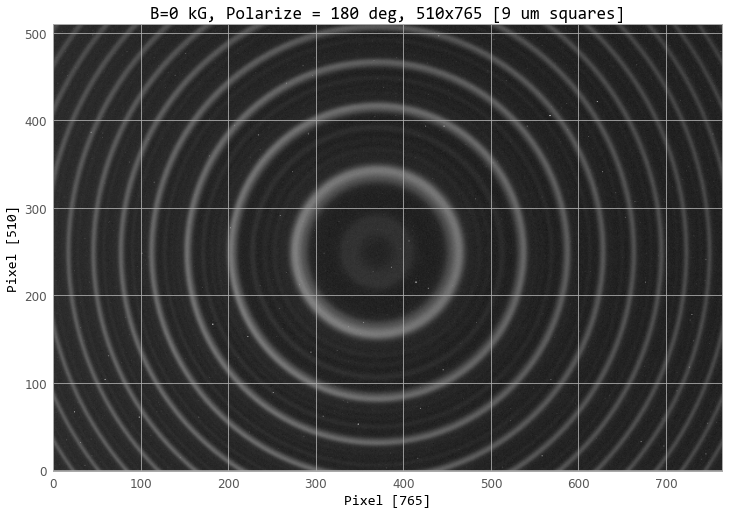

In [164]:
run1, run1_data, run1_info = GetImage('180NoBRun1Image.fit')
PlotRings(run1_data, 'B=0 kG, Polarize = 180 deg, 510x765 [9 um squares]', 'Pixel [765]', 'Pixel [510]')


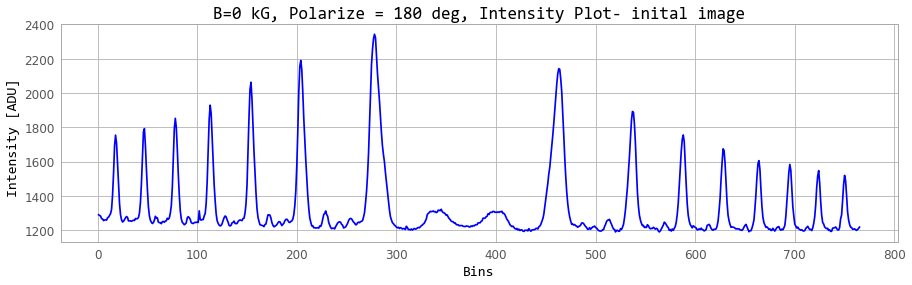

In [142]:
bins, intensities  = CreateData('180NoBRun1.txt')
bins, intensities =  np.array(bins), np.array(intensities)
Plots(bins, intensities, "B=0 kG, Polarize = 180 deg, Intensity Plot- inital image", 'Bins', 'Intensity [ADU] ')


Default input parameters overriden
[2.393e+03 3.070e+02 8.000e-01]
[1084.99997721  277.92042669    5.69955792]


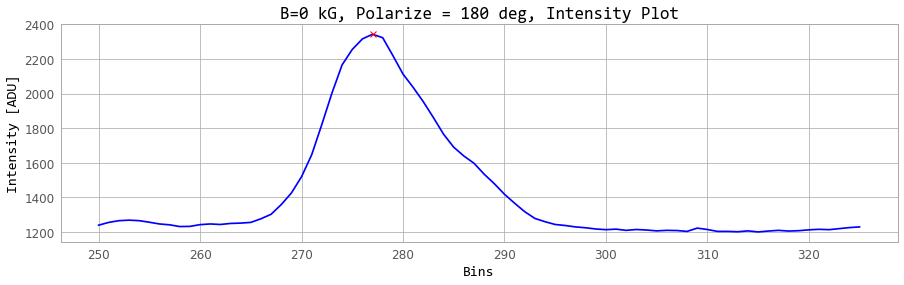

In [143]:
# select peak we want to fit 
ptru, xdata, ydata = LabelPeaks_ShrinkData(bins, intensities, 250, 325, 1400)
Plots(xdata, ydata,"B=0 kG, Polarize = 180 deg, Intensity Plot", 'Bins', 'Intensity [ADU]')
PlotNewPeaks(ptru, intensities)

#fit
params, peaktru = PeakBinValuesbyfit(ZeemanPeakfit, xdata, ydata, ptru, intensities, 50, 30, p0 = [.8])
print(params)

# Need to determine error in y data to get chi2 

Chi-square:  58.223448952141894
Degrees of freedom:  73
Reduced chi-square:  0.7975814924950945
CDF:  0.10372753217558565
p-test value:  0.8962724678244144


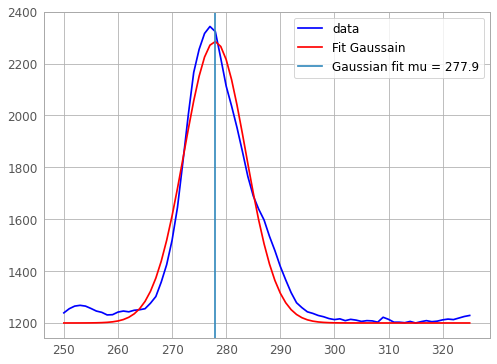

In [144]:
yfit = ZeemanPeakfit(xdata,*params)
plt.plot(xdata, ydata, color = 'blue', label = 'data')
plt.plot(xdata, yfit, color = 'red', label = 'Fit Gaussain')
plt.axvline(peaktru, label = f'Gaussian fit mu = {peaktru:.1f}')
plt.legend()


ysigma = np.random.uniform(50,70,len(yfit))
chisq = sum( (ydata - yfit)**2 / ysigma**2 )

ndf = len(ydata)-len(params)

chisq_reduced = chisq/float(ndf)

cdf = stat.chi2.cdf(chisq, df = ndf)

pvalue = 1-cdf

print('Chi-square: ',chisq)
print('Degrees of freedom: ',ndf)
print('Reduced chi-square: ',chisq_reduced)
print('CDF: ', cdf)
print('p-test value: ',pvalue)

Default input parameters overriden
[2.192e+03 4.720e+02 8.000e-01]
[904.50854724 461.19771      5.83828663]


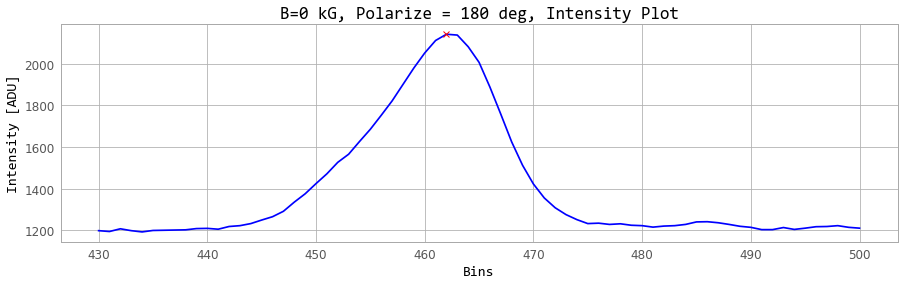

In [145]:
# select peak we want to fit 
ptru2, xdata2, ydata2 = LabelPeaks_ShrinkData(bins, intensities, 430, 500, 1400)
Plots(xdata2, ydata2,"B=0 kG, Polarize = 180 deg, Intensity Plot", 'Bins', 'Intensity [ADU]')
PlotNewPeaks(ptru2, intensities)
params2, peaktru2 = PeakBinValuesbyfit(ZeemanPeakfit, xdata2, ydata2, ptru2, intensities, 50, 10, p0 = [.8])
print(params2)

Chi-square:  28.61242110700045
Degrees of freedom:  68
Reduced chi-square:  0.42077089863235956
CDF:  6.722819593409261e-06
p-test value:  0.9999932771804065


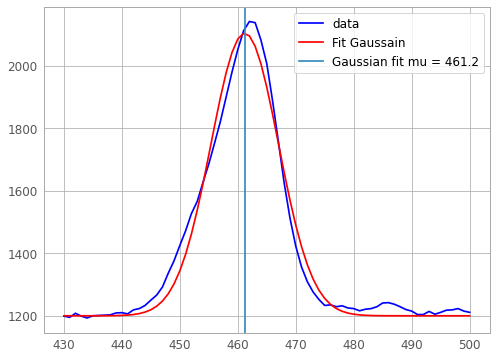

In [146]:
yfit2 = ZeemanPeakfit(xdata2,*params2)
plt.plot(xdata2, ydata2, color = 'blue', label = 'data')
plt.plot(xdata2, yfit2, color = 'red', label = 'Fit Gaussain')
plt.axvline(peaktru2, label = f'Gaussian fit mu = {peaktru2:.1f}')
plt.legend()

ysigma2 = np.random.uniform(50,70,len(yfit2))
chisq = sum( (ydata2 - yfit2)**2 / ysigma2**2 )

ndf = len(ydata2)-len(params2)

chisq_reduced = chisq/float(ndf)

cdf = stat.chi2.cdf(chisq, df = ndf)

pvalue = 1-cdf

print('Chi-square: ',chisq)
print('Degrees of freedom: ',ndf)
print('Reduced chi-square: ',chisq_reduced)
print('CDF: ', cdf)
print('p-test value: ',pvalue)

In [147]:
r1 = RadiusMicoMeter(ptru, ptru2)
print(r1)

[832.5]


# TEST THE SPLIT

Filename: 180Run12image.fit
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      38   (765, 510)   int16 (rescales to uint16)   


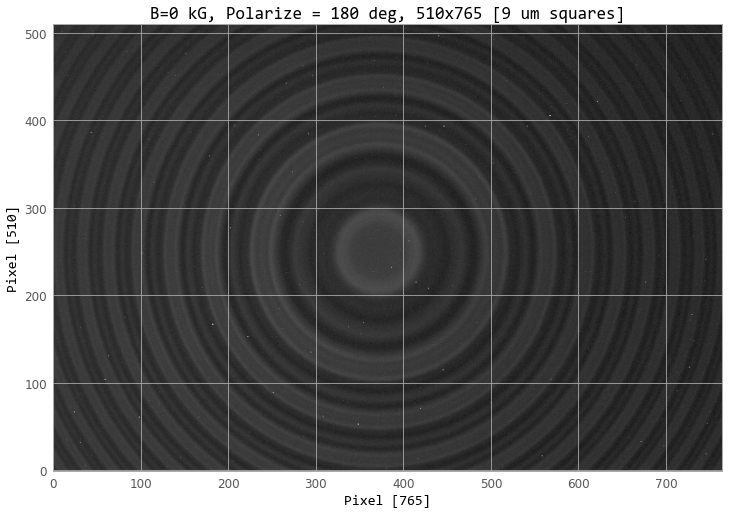

In [163]:
run1, run1_data, run1_info = GetImage('180Run12image.fit')
PlotRings(run1_data, 'B=0 kG, Polarize = 180 deg, 510x765 [9 um squares]', 'Pixel [765]', 'Pixel [510]')


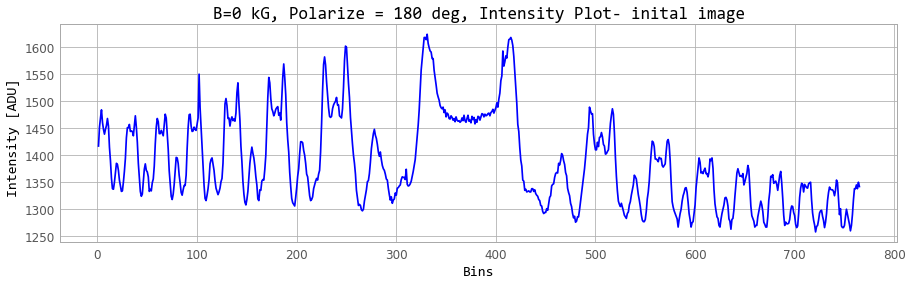

In [148]:
bins3, intensities3  = CreateData('180Run12.txt')
bins3, intensities3 =  np.array(bins3), np.array(intensities3)
Plots(bins3, intensities3, "B=0 kG, Polarize = 180 deg, Intensity Plot- inital image", 'Bins', 'Intensity [ADU] ')


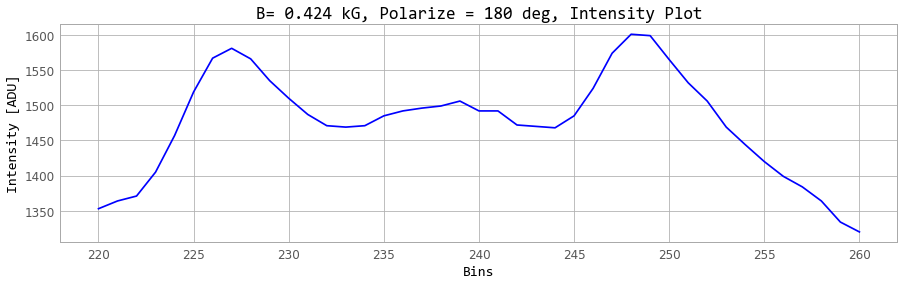

In [159]:
# select peak we want to fit 
ptru3, xdata3, ydata3 = LabelPeaks_ShrinkData(bins3, intensities3, 220, 260, 1350)
Plots(xdata3, ydata3,"B= 0.424 kG, Polarize = 180 deg, Intensity Plot", 'Bins', 'Intensity [ADU]')

